## Overview

Once the system has selected a candidate set of tables for answering a user's question, we need to identify the most likely single table which should be selected in order the answer the user's query. This is evaluted by determining the frequency with which the correct table is selected, from a candidate set which includes the expected answer.

## Metrics

Here we are interested in the frequency with which the system selects the correct answer from candidate sets of different sizes, given that the candidate set contains the correct answer. As this is a simple right/wrong scenario, we just measure accuracy as the 
proportion of correct answers given. In the evaluation of the candidate table retrieval, we noted that for larger values of k, we see diminishing returns in recall, so here we cap the evaluation at k=70.

## Conclusion

As expected, as the size of the candidate set of tables increases, we see diminishing accuracy as there are more options to choose from. The selection of the correct table is very challenging; there are many tables which, to a human analyst, would appear relevant to a given question, so although the baseline human performance is not known, it is likely to be substantially below 100%. The results shown below are relatively poor, but the algorithm does at least perform about twice as well as random selection (~40% accuracy with 5 candidates, ~20% with 10 candidates), so there is a base signal that can be iterated and improved upon.  

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
# read in the records
from tomoro.record import read_records

data_path = '../data/train.json'
all_records = read_records(data_path)
len(all_records)

3037

In [13]:
import random

# use a random sample of the records
records = random.sample(all_records, 100)
len(records)

100

In [14]:
from tomoro.utils import make_table_name

# the correct answer for the required table name is derived from the record id 
questions = []
expected_table_names = []

for record in records:
    table_name = make_table_name(record.id)
    qs = [qa.question for qa in record.qa]
    questions.extend(qs)
    expected_table_names.extend([table_name] * len(qs))

print(len(questions), len(expected_table_names))

138 138


In [18]:
from tomoro.vector_store import get_store
from tomoro.config import get_env_var
from tqdm import tqdm 

# for each question, we get the results for the max value of k, and then truncate during each evaluation step 
# for large values of k we get diminishing returns in recall, so cap evaluation at k=70
max_k = 70

store_type = get_env_var('VECTOR_STORE')
db_path = '../.vector_db'
collection_name = get_env_var('VECTOR_DB_COLLECTION_NAME')

vector_store = get_store(store_type, db_path=db_path, collection_name=collection_name)
results = []
for question in tqdm(questions):
    documents = vector_store.retrieve(question, k=max_k) 
    table_names = [d.metadata['table_name'] for d in documents]
    results.append(table_names)
len(results)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:17<00:00,  1.79it/s]


138

In [ ]:
# now evaluate table selection for different values of k
from langchain_community.utilities import SQLDatabase
from tomoro.utils import get_llm
from tomoro.sql import SQLGenerator
from tomoro.retrieve import Retriever

SQL_DB_NAME = get_env_var('SQL_DB_NAME')
sqlite_uri = f'sqlite:///../{SQL_DB_NAME}'
sql_db = SQLDatabase.from_uri(sqlite_uri)
LLM_TYPE = get_env_var('LLM')
llm = get_llm(LLM_TYPE)
sql_generator = SQLGenerator(sqlite_uri, llm)
retriever = Retriever(vector_store, llm, sql_db, sql_generator)

eval_results = []
for k in tqdm(range(5, max_k + 5, 5)):
    correct = 0
    incorrect = 0
    for question, q_expected_name, q_results in zip(questions, expected_table_names, results):
        # truncate the results to k - 1
        k_results = set(q_results[:k])
        if q_expected_name not in k_results:  # add it in
            q_results = q_results[:k-1]
            q_results.append(q_expected_name)
            k_results = set(q_results)

        table_info = sql_db.get_table_info_no_throw(k_results)
        selected_table = retriever.get_best_table_name(question, table_info)
        if selected_table == q_expected_name:
            correct += 1
        else:
            incorrect += 1
    accuracy = correct / len(questions)
    eval_results.append((k, accuracy, correct, incorrect))


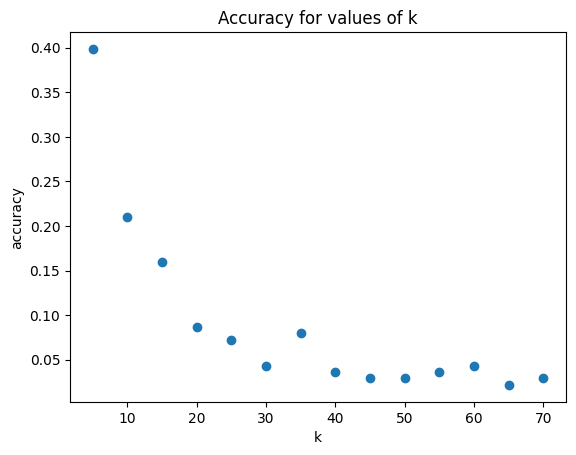

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(eval_results, columns=['k', 'accuracy', 'correct', 'incorrect'])
plt.title('Accuracy for values of k')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(x=df['k'], y=df['accuracy'])